In [1]:
import zlib
import numpy as np

def approximate_kolmogorov_complexity(sequence):
    """
    Approximates the Kolmogorov Complexity of a numeric sequence by:
      1. Converting it to bytes (strings).
      2. Compressing it with zlib.
      3. Using the length of the compressed data as a proxy for complexity.
    """
    # Convert the numeric sequence to a string
    # For real data, you may want a different way of encoding floats/integers
    byte_string = str(sequence).encode('utf-8')
    
    # Compress using zlib
    compressed_data = zlib.compress(byte_string)
    
    # The length (in bytes) of compressed data is our approximate complexity
    return len(compressed_data)

# ------------------------------------------------------------
# 1. Generate Synthetic Data
# ------------------------------------------------------------

np.random.seed(42)

# Create time axis
time = np.arange(0, 1000, 1)

# Signal A: purely random
A = np.random.randn(len(time))

# Signal B1: partially dependent on A
# e.g., B1 = 0.8*A + random noise
B1 = 0.8 * A + 0.3 * np.random.randn(len(time))

# Signal B2: purely independent random data
B2 = np.random.randn(len(time))

# ------------------------------------------------------------
# 2. Approximate Complexity (KC) 
# ------------------------------------------------------------

kc_A = approximate_kolmogorov_complexity(A)
kc_B1 = approximate_kolmogorov_complexity(B1)
kc_B2 = approximate_kolmogorov_complexity(B2)

kc_AB1 = approximate_kolmogorov_complexity(np.column_stack((A, B1)))
kc_AB2 = approximate_kolmogorov_complexity(np.column_stack((A, B2)))

# Print results
print("Approximate KC:")
print(f"K(A)         = {kc_A}")
print(f"K(B1)        = {kc_B1}")
print(f"K(B2)        = {kc_B2}")
print(f"K(A,B1)      = {kc_AB1}")
print(f"K(A,B2)      = {kc_AB2}")

# Look at whether K(A,B1) < K(A) + K(B1), etc.
print("\nComparisons:")
print(f"K(A,B1) vs. K(A)+K(B1): {kc_AB1} vs. {kc_A + kc_B1}")
print(f"K(A,B2) vs. K(A)+K(B2): {kc_AB2} vs. {kc_A + kc_B2}")


Approximate KC:
K(A)         = 6545
K(B1)        = 6578
K(B2)        = 6590
K(A,B1)      = 107
K(A,B2)      = 107

Comparisons:
K(A,B1) vs. K(A)+K(B1): 107 vs. 13123
K(A,B2) vs. K(A)+K(B2): 107 vs. 13135


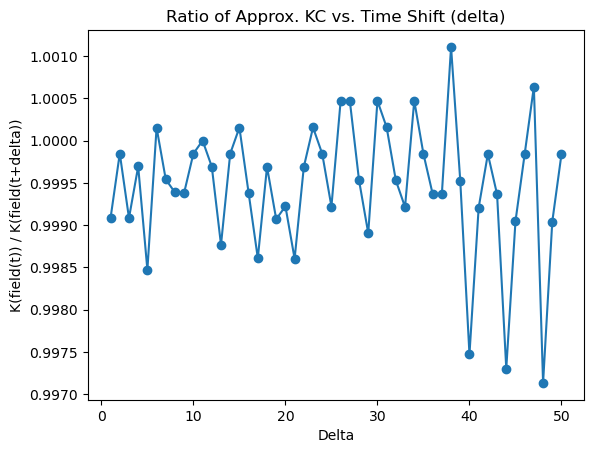

In [2]:
import numpy as np
import zlib
import matplotlib.pyplot as plt

def approximate_kolmogorov_complexity(sequence):
    """
    Approximates Kolmogorov Complexity of a numeric sequence by:
      1) Converting to a string (or bytes).
      2) Compressing it with zlib.
      3) Using the compressed length as a proxy for complexity.
    """
    # Convert numeric sequence to a string (basic approach)
    byte_string = str(sequence).encode('utf-8')
    
    # Compress
    compressed_data = zlib.compress(byte_string)
    
    # Return length (in bytes) of the compressed data
    return len(compressed_data)

def measure_kc_ratio_over_deltas(data, max_delta=50):
    """
    For each delta in [1 .. max_delta], compute:
        K( field(t) ) / K( field(t+delta) )
    where we define field(t) = data[0 : N-delta]
          and field(t+delta) = data[delta : N].
    Returns two lists: deltas and ratio_values.
    """
    ratio_values = []
    N = len(data)
    # Ensure max_delta is not larger than the length of the data
    max_delta = min(max_delta, N - 1)

    for delta in range(1, max_delta + 1):
        # Define "field(t)" as data[:N-delta]
        # Define "field(t+delta)" as data[delta:]
        sub_data_1 = data[0 : N - delta]
        sub_data_2 = data[delta : N]

        K1 = approximate_kolmogorov_complexity(sub_data_1)
        K2 = approximate_kolmogorov_complexity(sub_data_2)

        ratio = K1 / K2 if K2 != 0 else np.nan
        ratio_values.append(ratio)
    
    return list(range(1, max_delta + 1)), ratio_values

# ----------------------------------------------------------------
# Example Usage
# ----------------------------------------------------------------

# 1. Generate synthetic data
np.random.seed(0)
time = np.arange(0, 1000, 1)
# Example random time series (could be any dynamic field)
data = np.random.randn(len(time))

# 2. Measure ratio of complexities for deltas up to 50
deltas, ratio_values = measure_kc_ratio_over_deltas(data, max_delta=50)

# 3. Plot the ratio as a function of delta
plt.plot(deltas, ratio_values, marker='o')
plt.xlabel('Delta')
plt.ylabel('K(field(t)) / K(field(t+delta))')
plt.title('Ratio of Approx. KC vs. Time Shift (delta)')
plt.show()


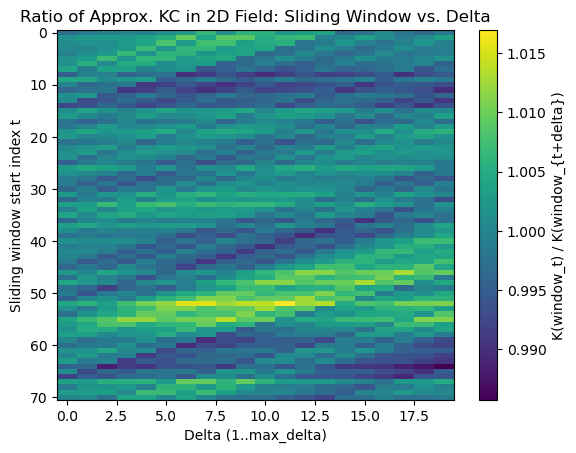

In [3]:
import numpy as np
import zlib
import matplotlib.pyplot as plt

def approximate_kolmogorov_complexity(array_2d):
    """
    Approximate Kolmogorov Complexity for a 2D array by:
      1) Converting it to a bytes string.
      2) Compressing it with zlib.
      3) Using the compressed length as a proxy for complexity.
    """
    # Convert numeric array to string in a simple way.
    # For real data, consider more robust serialization (e.g., struct.pack).
    byte_string = str(array_2d.tolist()).encode('utf-8')
    compressed_data = zlib.compress(byte_string)
    return len(compressed_data)

def measure_kc_ratio_sliding_window_2d(data_2d, window_size=10, max_delta=20):
    """
    For each delta in [1..max_delta],
      and for each valid start index t in [0..(T - window_size - delta)],
    compute the ratio:
        K( window[t : t+window_size, :] )
          / K( window[t+delta : t+delta+window_size, :] ).
    
    Returns:
      - ratio_map: 2D numpy array of shape (num_t, max_delta), where
           ratio_map[t, (delta-1)] is the ratio for that t and delta.
      - valid_t_values: the range of t for which we compute ratios.
    
    data_2d has shape (T, M) for T "time steps" and M "spatial" points.
    """
    T, M = data_2d.shape
    # The maximum valid t index is T - window_size - delta
    # so the number of valid t values is at most T - window_size - 1
    # (minus any extra to accommodate max_delta).
    max_possible_t = T - window_size  # upper bound for starting the first window
    ratio_map = []

    # We will collect ratio rows in ratio_map (one row per t)
    valid_t_values = []
    
    # For each t from 0..(T - window_size - max_delta) so we can do all deltas
    for t in range(max_possible_t - max_delta + 1):
        row_ratios = []
        # Extract the first window
        window1 = data_2d[t : t + window_size, :]

        K1 = approximate_kolmogorov_complexity(window1)

        # Now iterate over deltas
        for delta in range(1, max_delta + 1):
            # The second window starts at t+delta
            start_2 = t + delta
            end_2 = start_2 + window_size
            window2 = data_2d[start_2 : end_2, :]
            
            K2 = approximate_kolmogorov_complexity(window2)
            ratio = K1 / K2 if K2 != 0 else np.nan
            row_ratios.append(ratio)
        
        ratio_map.append(row_ratios)
        valid_t_values.append(t)

    ratio_map = np.array(ratio_map)  # shape: (num_t, max_delta)
    return ratio_map, valid_t_values

# ----------------------------------------------------------------
# EXAMPLE USAGE
# ----------------------------------------------------------------

# 1. Generate a random 2D field
#    Let's say rows = time steps, columns = spatial points
np.random.seed(0)
T = 100   # Number of "time" steps
M = 20    # Number of "spatial" points
data_2d = np.random.randn(T, M)

# 2. Define parameters
window_size = 10
max_delta = 20  # how far forward we shift

# 3. Compute ratio of complexities in a sliding-window manner
ratio_map, valid_t = measure_kc_ratio_sliding_window_2d(data_2d, window_size, max_delta)

# 4. Plot the results as a function of t (vertical axis) and delta (horizontal axis)
plt.imshow(ratio_map, aspect='auto', origin='upper')
plt.colorbar(label='K(window_t) / K(window_{t+delta})')
plt.xlabel('Delta (1..max_delta)')
plt.ylabel('Sliding window start index t')
plt.title('Ratio of Approx. KC in 2D Field: Sliding Window vs. Delta')
plt.show()
